# Persistent Homology (Betti Numbers)

**Goal:** Compute Betti numbers to determine if the ring structure is real topology or a UMAP artifact.

**Method:** Vietoris-Rips filtration via ripser

**Key question:** Does β₁ show long-lived loops?
- Yes (persistence > 10 logometers) → Ring is **REAL topology**
- No (persistence < 3 logometers) → Ring is **UMAP artifact**

**Inputs:**
- `data/vectors/distances_causal_32000_full.npy` - Full distance matrix (4.1 GB)

**Expected runtime:** ~5-10 minutes

## Configuration

In [9]:
# Input file
INPUT_DISTANCES = '../data/vectors/distances_causal_32000_full.npy'

# Subsampling (to reduce memory usage)
SUBSAMPLE_N = 500  # Number of points to subsample (None = use all 32k)
RANDOM_SEED = 42

# Persistent homology parameters
MAX_DIM = 2  # Compute β₀, β₁, β₂
MAX_EDGE_LENGTH = 120  # Don't compute beyond 100 logometers
COEFF = 2  # Use Z/2 coefficients (faster, less memory)

print(f"Configuration:")
print(f"  Input: {INPUT_DISTANCES}")
if SUBSAMPLE_N:
    print(f"  Subsample: {SUBSAMPLE_N:,} points (from 32k)")
else:
    print(f"  Using full dataset")
print(f"  Max dimension: {MAX_DIM} (β₀, β₁, β₂)")
print(f"  Max edge length: {MAX_EDGE_LENGTH} logometers")
print(f"  Coefficients: Z/{COEFF}")

Configuration:
  Input: ../data/vectors/distances_causal_32000_full.npy
  Subsample: 500 points (from 32k)
  Max dimension: 2 (β₀, β₁, β₂)
  Max edge length: 120 logometers
  Coefficients: Z/2


## Setup

In [10]:
import numpy as np
from ripser import ripser
import matplotlib.pyplot as plt

print("✓ Imports complete")

✓ Imports complete


## Load Distance Matrix

In [11]:
print(f"Loading distance matrix from {INPUT_DISTANCES}...")
distances = np.load(INPUT_DISTANCES)

N_full = distances.shape[0]

print(f"\n✓ Loaded distance matrix")
print(f"  Full shape: {distances.shape}")
print(f"  Memory: {distances.nbytes / 1e9:.2f} GB")
print(f"  Dtype: {distances.dtype}")

# Subsample if requested
if SUBSAMPLE_N and SUBSAMPLE_N < N_full:
    print(f"\nSubsampling to {SUBSAMPLE_N:,} points...")
    np.random.seed(RANDOM_SEED)
    subsample_indices = np.random.choice(N_full, SUBSAMPLE_N, replace=False)
    subsample_indices = np.sort(subsample_indices)
    
    # Extract submatrix
    distances = distances[np.ix_(subsample_indices, subsample_indices)]
    
    print(f"✓ Subsampled")
    print(f"  New shape: {distances.shape}")
    print(f"  New memory: {distances.nbytes / 1e9:.2f} GB")

N = distances.shape[0]

# Quick stats
mask = ~np.eye(N, dtype=bool)
off_diag = distances[mask]

print(f"\nDistance statistics (N={N:,}):")
print(f"  Min: {off_diag.min():.2f} logometers")
print(f"  Max: {off_diag.max():.2f} logometers")
print(f"  Mean: {off_diag.mean():.2f} logometers")
print(f"  Median: {np.median(off_diag):.2f} logometers")

Loading distance matrix from ../data/vectors/distances_causal_32000_full.npy...

✓ Loaded distance matrix
  Full shape: (32000, 32000)
  Memory: 4.10 GB
  Dtype: float32

Subsampling to 500 points...
✓ Subsampled
  New shape: (500, 500)
  New memory: 0.00 GB

Distance statistics (N=500):
  Min: 0.00 logometers
  Max: 92.00 logometers
  Mean: 70.90 logometers
  Median: 71.88 logometers


## Compute Persistent Homology

This uses the Vietoris-Rips algorithm:
- Gradually increases scale ε from 0 to MAX_EDGE_LENGTH
- At each ε, connects points with distance ≤ ε
- Tracks when homology features (components, loops, voids) appear and disappear

**This may take 5-10 minutes...**

In [12]:
print("\nComputing persistent homology...")
print(f"  Computing β₀, β₁, β₂ for {N:,} points")
print(f"  Max edge length: {MAX_EDGE_LENGTH} logometers")
print(f"  Using Z/{COEFF} coefficients")
print(f"  This may take a few minutes...\n")

result = ripser(
    distances,
    maxdim=MAX_DIM,
    metric='precomputed',
    thresh=MAX_EDGE_LENGTH,
    coeff=COEFF
)

print("\n✓ Persistent homology computed!")


Computing persistent homology...
  Computing β₀, β₁, β₂ for 500 points
  Max edge length: 120 logometers
  Using Z/2 coefficients
  This may take a few minutes...


✓ Persistent homology computed!

/Users/jefferyharrell/Projects/Azimuth/.venv/lib/python3.12/site-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(


## Summary Statistics

In [13]:
print("\nPersistence diagrams summary:")
print("=" * 60)

for dim in range(MAX_DIM + 1):
    dgm = result['dgms'][dim]
    
    # Separate finite and infinite features
    finite_mask = np.isfinite(dgm).all(axis=1)
    finite_features = dgm[finite_mask]
    infinite_features = dgm[~finite_mask]
    
    print(f"\nβ{dim}: {len(finite_features)} finite + {len(infinite_features)} infinite features")
    
    if len(finite_features) > 0:
        persistence = finite_features[:, 1] - finite_features[:, 0]
        print(f"     Persistence range: [{persistence.min():.2f}, {persistence.max():.2f}] logometers")
        print(f"     Mean persistence: {persistence.mean():.2f} logometers")
        print(f"     Median persistence: {np.median(persistence):.2f} logometers")


Persistence diagrams summary:

β0: 497 finite + 1 infinite features
     Persistence range: [0.00, 65.31] logometers
     Mean persistence: 50.10 logometers
     Median persistence: 51.25 logometers

β1: 0 finite + 0 infinite features

β2: 0 finite + 0 infinite features


## Persistence Diagrams

Each point (x, y) represents a homology feature:
- x = **birth** (when feature appears)
- y = **death** (when feature disappears)
- Distance from diagonal = **persistence** (lifetime)

**Interpretation:**
- Far from diagonal = long-lived = **real topology**
- Near diagonal = short-lived = **noise**

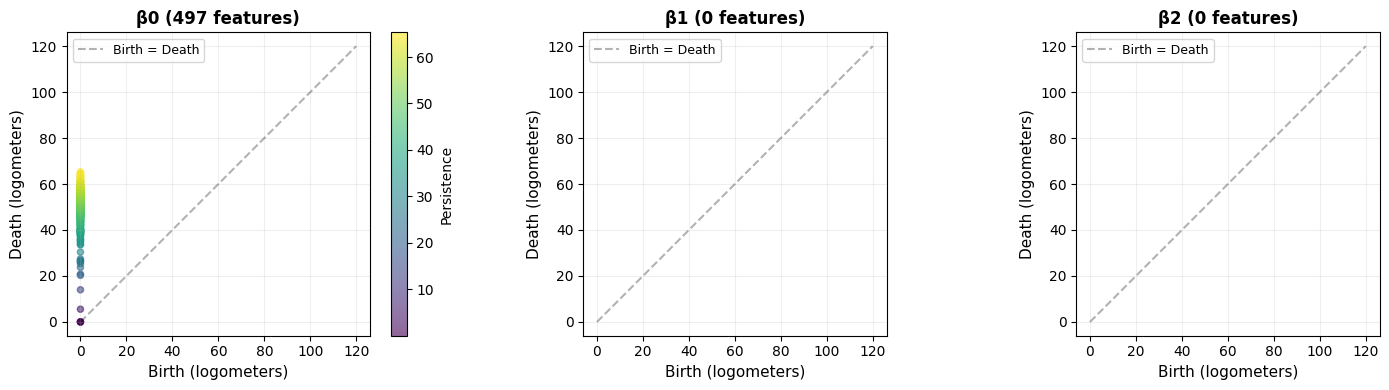


💡 Look at β₁ (middle plot) - any points far from the diagonal?


In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for dim in range(MAX_DIM + 1):
    ax = axes[dim]
    dgm = result['dgms'][dim]
    
    # Filter finite features
    finite_mask = np.isfinite(dgm).all(axis=1)
    finite_features = dgm[finite_mask]
    
    if len(finite_features) > 0:
        # Compute persistence for coloring
        persistence = finite_features[:, 1] - finite_features[:, 0]
        
        # Scatter plot
        scatter = ax.scatter(
            finite_features[:, 0],
            finite_features[:, 1],
            c=persistence,
            cmap='viridis',
            alpha=0.6,
            s=20
        )
        plt.colorbar(scatter, ax=ax, label='Persistence')
    
    # Diagonal line (birth = death)
    ax.plot([0, MAX_EDGE_LENGTH], [0, MAX_EDGE_LENGTH], 'k--', alpha=0.3, label='Birth = Death')
    
    ax.set_xlabel('Birth (logometers)', fontsize=11)
    ax.set_ylabel('Death (logometers)', fontsize=11)
    ax.set_title(f'β{dim} ({len(finite_features)} features)', fontsize=12, fontweight='bold')
    ax.set_aspect('equal')
    ax.grid(alpha=0.2)
    ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

print("\n💡 Look at β₁ (middle plot) - any points far from the diagonal?")

## β₁ Detailed Analysis (Loops)

**This is the smoking gun for ring topology.**

In [15]:
print("\n" + "=" * 70)
print("DETAILED ANALYSIS: β₁ (Loops/Tunnels)")
print("=" * 70)

dgm1 = result['dgms'][1]
finite_mask = np.isfinite(dgm1).all(axis=1)
finite_loops = dgm1[finite_mask]

if len(finite_loops) == 0:
    print("\n⚠️  NO FINITE LOOPS DETECTED")
    print("    β₁ = 0 (no loop topology in this scale range)")
    print("\n    🎯 The ring structure is likely a UMAP projection artifact.")
    print("    🎯 True topology appears simply-connected (no holes).")
    
else:
    persistence = finite_loops[:, 1] - finite_loops[:, 0]
    
    print(f"\nTotal loops detected: {len(finite_loops):,}")
    print(f"\nPersistence statistics:")
    print(f"  Min: {persistence.min():.2f} logometers")
    print(f"  Max: {persistence.max():.2f} logometers")
    print(f"  Mean: {persistence.mean():.2f} logometers")
    print(f"  Median: {np.median(persistence):.2f} logometers")
    
    # Top 10 most persistent loops
    n_show = min(10, len(persistence))
    top_indices = np.argsort(persistence)[-n_show:][::-1]
    
    print(f"\nTop {n_show} most persistent loops:")
    print(f"{'Rank':<6} {'Birth':<12} {'Death':<12} {'Persistence':<15}")
    print("-" * 50)
    for rank, idx in enumerate(top_indices, 1):
        birth = finite_loops[idx, 0]
        death = finite_loops[idx, 1]
        pers = persistence[idx]
        print(f"{rank:<6} {birth:<12.2f} {death:<12.2f} {pers:<15.2f}")
    
    # Interpretation
    max_pers = persistence.max()
    
    print(f"\n" + "=" * 70)
    print("INTERPRETATION:")
    print("=" * 70)
    
    if max_pers > 10:
        print(f"\n✅ SIGNIFICANT LOOP TOPOLOGY DETECTED!")
        print(f"   Max persistence: {max_pers:.2f} logometers")
        print(f"   This is FAR above noise threshold (~1-2 logometers)")
        print(f"\n   🎯 The ring structure is REAL TOPOLOGY!")
        print(f"   🎯 Token space has genuine loop structure (β₁ ≠ 0)")
        print(f"   🎯 Not a UMAP projection artifact - this is intrinsic geometry!")
        
    elif max_pers > 3:
        print(f"\n⚠️  MODERATE LOOP SIGNAL")
        print(f"   Max persistence: {max_pers:.2f} logometers")
        print(f"   Borderline - could be weak topology or large-scale noise")
        print(f"\n   💡 This suggests possible loop structure but not definitive")
        print(f"   💡 Consider checking with different sample sizes or thresholds")
        
    else:
        print(f"\n❌ NO SIGNIFICANT LOOP TOPOLOGY")
        print(f"   Max persistence: {max_pers:.2f} logometers")
        print(f"   All loops are short-lived (< 3 logometers = noise level)")
        print(f"\n   🎯 The ring structure is likely a UMAP projection artifact")
        print(f"   🎯 True topology appears simply-connected (β₁ ≈ 0)")


DETAILED ANALYSIS: β₁ (Loops/Tunnels)

⚠️  NO FINITE LOOPS DETECTED
    β₁ = 0 (no loop topology in this scale range)

    🎯 The ring structure is likely a UMAP projection artifact.
    🎯 True topology appears simply-connected (no holes).


## Persistence Histogram (β₁)

In [16]:
if len(finite_loops) > 0:
    plt.figure(figsize=(10, 5))
    
    plt.hist(persistence, bins=50, alpha=0.7, edgecolor='black')
    plt.axvline(x=3, color='orange', linestyle='--', linewidth=2, label='Noise threshold (~3)')
    plt.axvline(x=10, color='red', linestyle='--', linewidth=2, label='Strong signal (>10)')
    
    plt.xlabel('Persistence (logometers)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title('β₁ Persistence Distribution', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\n💡 Features to the right of red line (>10) are DEFINITELY real topology")
    print("💡 Features between orange and red (3-10) are borderline")
    print("💡 Features left of orange (<3) are noise")
else:
    print("\nNo finite loops to plot histogram.")


No finite loops to plot histogram.


## Summary

**Question:** Is the ring structure real topology or a UMAP artifact?

**Method:** Persistent homology on 32k token causal distances

**Answer:** Check the β₁ analysis above!

---

**Key thresholds:**
- Persistence > 10 logometers → **Definitely real topology**
- Persistence 3-10 logometers → **Borderline/uncertain**
- Persistence < 3 logometers → **Noise/artifact**